In [130]:
# Realizando import das variáveis necessárias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, balanced_accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

In [131]:
# Carregando o dataset
df = pd.read_csv('../data/lung_cancer_prediction_dataset.csv')
df.head()

,ID,Country,Population_Size,Age,Gender,Smoker,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,...,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Early_Detection,Treatment_Type,Developed_or_Developing,Annual_Lung_Cancer_Deaths,Lung_Cancer_Prevalence_Rate,Mortality_Rate
0,0,China,1400,80,Male,Yes,30,29,No,No,...,Low,Yes,No,Poor,No,NaN,Developing,690000,2.44,0.0
1,1,Iran,84,53,Male,No,0,0,Yes,No,...,Low,Yes,No,Poor,No,NaN,Developing,27000,2.10,0.0
2,2,Mexico,128,47,Male,Yes,12,6,Yes,No,...,Medium,No,No,Poor,Yes,NaN,Developing,28000,1.11,0.0
3,3,Indonesia,273,39,Female,No,0,0,No,Yes,...,Low,No,No,Poor,No,NaN,Developing,40000,0.75,0.0
4,4,South Africa,59,44,Female,No,0,0,Yes,No,...,Medium,Yes,No,Poor,No,NaN,Developing,15000,2.44,0.0


In [132]:
# Verificando a distribuição da variável alvo
df['Lung_Cancer_Diagnosis'].value_counts(normalize=True)

Lung_Cancer_Diagnosis
No     0.959385
Yes    0.040615
Name: proportion, dtype: float64

In [133]:
yes_df = df[df['Lung_Cancer_Diagnosis'] == "Yes"]
no_df = df[df['Lung_Cancer_Diagnosis'] =="No"]

distributed_n_df = no_df.sample(len(yes_df) * 4, random_state=42)
distributed_df = pd.concat([yes_df, distributed_n_df], ignore_index=True)

distributed_df['Lung_Cancer_Diagnosis'].value_counts(normalize=True)

Lung_Cancer_Diagnosis
No     0.8
Yes    0.2
Name: proportion, dtype: float64

In [134]:
# Verificando colunas com valores nulos
null_columns = distributed_df.columns[distributed_df.isnull().any()].tolist()
display(set(null_columns))

{'Cancer_Stage', 'Treatment_Type'}

In [135]:
# Removendo colunas que não são necessárias para o modelo
distributed_df = distributed_df.drop(columns=[
    'ID', 
    'Population_Size', 
    'Country', 
    'Mortality_Rate', 
    'Survival_Years', 
    'Cancer_Stage', 
    'Treatment_Type', 
    'Early_Detection',
    'Developed_or_Developing',  
    'Adenocarcinoma_Type', 
    'Annual_Lung_Cancer_Deaths'])
distributed_df.head()

,Age,Gender,Smoker,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,Lung_Cancer_Diagnosis,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Lung_Cancer_Prevalence_Rate
0,40,Female,Yes,11,17,No,No,Yes,Low,No,No,Poor,1.08
1,55,Male,Yes,9,8,No,Yes,Yes,Medium,Yes,No,Poor,1.28
2,33,Male,Yes,4,12,No,Yes,Yes,Medium,No,No,Poor,0.59
3,61,Male,Yes,14,28,No,No,Yes,Low,No,Yes,Good,1.66
4,70,Male,Yes,7,21,No,No,Yes,Medium,Yes,No,Poor,2.16


In [136]:
# Removendo colunas nulas
for col in null_columns:
    distributed_df.fillna({col: "Unknown"}, inplace=True)

distributed_df.head()

,Age,Gender,Smoker,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,Lung_Cancer_Diagnosis,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Lung_Cancer_Prevalence_Rate
0,40,Female,Yes,11,17,No,No,Yes,Low,No,No,Poor,1.08
1,55,Male,Yes,9,8,No,Yes,Yes,Medium,Yes,No,Poor,1.28
2,33,Male,Yes,4,12,No,Yes,Yes,Medium,No,No,Poor,0.59
3,61,Male,Yes,14,28,No,No,Yes,Low,No,Yes,Good,1.66
4,70,Male,Yes,7,21,No,No,Yes,Medium,Yes,No,Poor,2.16


In [137]:
# Normalizando as colunas
labels_to_analisy = [
    'Age',
    'Gender',
    'Smoker',
    'Years_of_Smoking',
    'Cigarettes_per_Day',
    'Passive_Smoker',
    'Family_History',
    "Indoor_Pollution",
    "Occupational_Exposure"
]

le = LabelEncoder()
labels_to_encode = [
    "Lung_Cancer_Diagnosis",
    "Gender",
    "Smoker",
    "Passive_Smoker",
    "Indoor_Pollution",
    "Family_History",
    "Occupational_Exposure"
]

for label in labels_to_encode:
    distributed_df[label] = le.fit_transform(distributed_df[label])


ohe = OneHotEncoder(sparse_output=False)
labels_hot_encode = [
    "Air_Pollution_Exposure",
    "Healthcare_Access",
]

for label in labels_hot_encode:
    encoded = ohe.fit_transform(distributed_df[[label]])
    distributed_df = distributed_df.join(pd.DataFrame(encoded, columns=ohe.get_feature_names_out([label])))
    distributed_df.drop(columns=[label], inplace=True)
    labels_to_analisy.extend(ohe.get_feature_names_out([label]))

print(labels_to_analisy)

['Age', 'Gender', 'Smoker', 'Years_of_Smoking', 'Cigarettes_per_Day', 'Passive_Smoker', 'Family_History', 'Indoor_Pollution', 'Occupational_Exposure', 'Air_Pollution_Exposure_High', 'Air_Pollution_Exposure_Low', 'Air_Pollution_Exposure_Medium', 'Healthcare_Access_Good', 'Healthcare_Access_Poor']


In [138]:
# Definindo as variáveis dependentes e independentes
y = distributed_df['Lung_Cancer_Diagnosis']
x = distributed_df[labels_to_analisy]

In [139]:
# Dividindo o dataset em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [140]:
# Normalizando os dados
scaler = MinMaxScaler() 
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled= scaler.transform(x_test)

In [141]:
knn_errs = []
for i in range(1, 10):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(x_train_scaled, y_train)
    y_pred = knn_model.predict(x_test_scaled)
    knn_errs.append(1 - accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Error Rate')

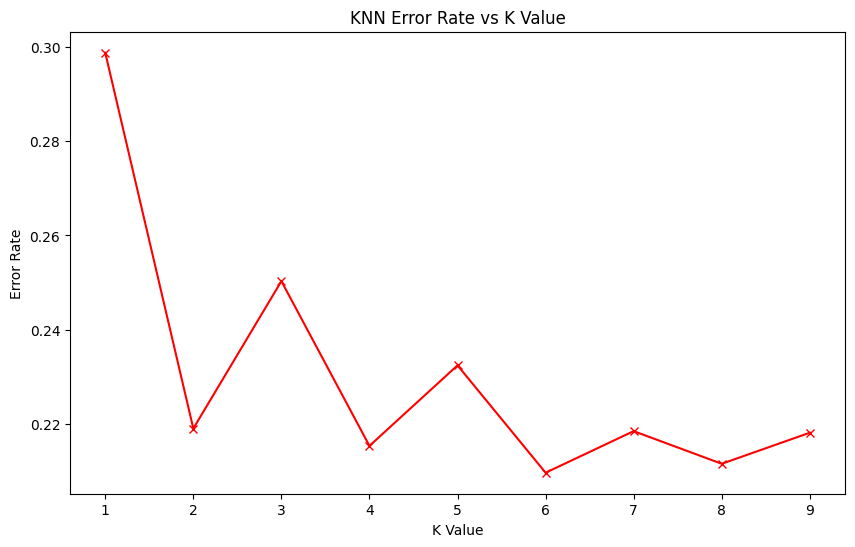

In [142]:
plt.figure(figsize=(10,6))
plt.plot(range(1, 10), knn_errs, marker='x', color='red')
plt.title('KNN Error Rate vs K Value')
plt.xlabel('K Value')
plt.ylabel('Error Rate')

In [143]:

# Hyperparameter Tuning
knn_param_grid = {
       'n_neighbors': [4, 6, 8],
       'weights': ['uniform', 'distance'],
       'metric': ['cosine', 'euclidean', 'manhattan']
}
knn_gs_metric = make_scorer(accuracy_score)

knn_grid_search = GridSearchCV(
       KNeighborsClassifier(),
       param_grid=knn_param_grid,
       scoring=knn_gs_metric, 
       cv=5,
       n_jobs=4,
       verbose=3
)

knn_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 4/5] END metric=cosine, n_neighbors=4, weights=uniform;, score=0.786 total time=  12.9s
[CV 2/5] END metric=cosine, n_neighbors=4, weights=uniform;, score=0.780 total time=  13.4s
[CV 3/5] END metric=cosine, n_neighbors=4, weights=uniform;, score=0.781 total time=  13.4s
[CV 1/5] END metric=cosine, n_neighbors=4, weights=uniform;, score=0.784 total time=  13.9s
[CV 5/5] END metric=cosine, n_neighbors=4, weights=uniform;, score=0.786 total time=   5.0s
[CV 2/5] END metric=cosine, n_neighbors=4, weights=distance;, score=0.742 total time=   4.8s
[CV 1/5] END metric=cosine, n_neighbors=4, weights=distance;, score=0.742 total time=   5.5s
[CV 3/5] END metric=cosine, n_neighbors=4, weights=distance;, score=0.745 total time=   5.3s
[CV 4/5] END metric=cosine, n_neighbors=4, weights=distance;, score=0.750 total time=   6.6s
[CV 5/5] END metric=cosine, n_neighbors=4, weights=distance;, score=0.745 total time=   7.4s
[CV 2/5] END m

,estimator,KNeighborsClassifier()
,param_grid,"{'metric': ['cosine', 'euclidean', ...], 'n_neighbors': [4, 6, ...], 'weights': ['uniform', 'distance']}"
,scoring,make_scorer(a...hod='predict')
,n_jobs,4
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,8


In [144]:
print(f'BEST PARAMS: {knn_grid_search.best_params_}')

BEST PARAMS: {'metric': 'cosine', 'n_neighbors': 8, 'weights': 'uniform'}


In [145]:
def cross_validation(x_axis, y_axis):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier

    x = x_axis
    y = y_axis

    kfold  = KFold(n_splits=10, shuffle=True, random_state=42)

    #KNN
    knn = KNeighborsClassifier(n_neighbors=8, metric= 'cosine', weights='uniform') 
    knn.fit(x_train_scaled, y_train) 

    #Random Forest
    rf = RandomForestClassifier(random_state=7) 
    rf.fit(x_train_scaled, y_train) 

    #Decision Tree
    dt = DecisionTreeClassifier(random_state=7)
    dt.fit(x_train_scaled, y_train)

    knn_result = cross_val_score(knn, x, y, cv = kfold)
    rf_result = cross_val_score(rf, x, y, cv = kfold)
    dt_result = cross_val_score(dt, x, y, cv = kfold)

    dic_models = {
        "KNN": knn_result.mean(),
        "RF": rf_result.mean(),
        "DT": dt_result.mean()
    }
    best_model = max(dic_models, key=dic_models.get)

    print("KNN (R^2): {0}\nRF (R^2): {1}\nDT (R^2): {2}".format(knn_result.mean(), rf_result.mean(), dt_result.mean()))
    print("O melhor modelo é : {0} com o valor: {1}".format(best_model, dic_models[best_model]))


In [146]:
cross_validation(x, y)

KNN (R^2): 0.7882382011748016
RF (R^2): 0.7694008482242485
DT (R^2): 0.7323963281474161
O melhor modelo é : KNN com o valor: 0.7882382011748016


In [ ]:
# Só executar quando o melhor modelo não for o KNN
# from sklearn.ensemble import RandomForestClassifier
# rf_gs_metric = make_scorer(accuracy_score)

# rf_grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=7),
#     param_grid={
#         'n_estimators': [10, 11],
#         'max_depth': [6, 7],
#         'min_samples_split': [8, 9],
#         'min_samples_leaf': [4, 5],
#         'max_features': [8, 9]
#     },
#     scoring=rf_gs_metric,
#     cv=5,
#     n_jobs=4,
#     verbose=3
# )
# rf_grid_search.fit(x_train_scaled, y_train)

In [ ]:
# print(f'BEST PARAMS: {rf_grid_search.best_params_}')

In [148]:
# Treinando o modelo com os melhores parâmetros encontrados
model = knn_grid_search.best_estimator_


model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [149]:
print('Training set score: {:.4f}'.format(model.score(x_train_scaled, y_train)))
print('Test set score: {:.4f}'.format(model.score(x_test_scaled, y_test)))

Training set score: 0.7874
Test set score: 0.7898


In [150]:
ac = accuracy_score(y_test, y_pred)
print(f'Acuracy:\t\t{ac:.1%}')


print(classification_report(y_test, y_pred))

# y_prob = model.predict_proba(x_test)[:, -1]
# auc_score = roc_auc_score(y, y_prob)
# print(f"AUC-ROC: {auc_score:.2%}")
# print(f"GINI: {(2 * auc_score - 1):.2%}")

Acuracy:		78.7%
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      7169
           1       0.29      0.04      0.08      1792

    accuracy                           0.79      8961
   macro avg       0.54      0.51      0.48      8961
weighted avg       0.70      0.79      0.72      8961



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


print(y_test.value_counts())


# matrix_labels = labels_to_analisy + ['Lung_Cancer_Diagnosis']
# matriz_confusao = confusion_matrix(y_true = y_test,
#                                    y_pred = y_pred,
#                                    labels=matrix_labels)

# figure = plt.figure(figsize=(15, 5))
# disp = ConfusionMatrixDisplay(confusion_matrix = matriz_confusao,
#                               display_labels=labels_to_analisy)
# disp.plot(values_format='d') 